### Execute the pipeline

```bash
uv run papermill \
  pretrain-datasets/fineweb-2-edu-korean/fineweb-2-edu-korean.ipynb \
  pretrain-datasets/fineweb-2-edu-korean/output.ipynb
```

### Monitor the progress

```bash
watch -n 1 "cat pretrain-datasets/fineweb-2-edu-korean/output.ipynb| jq -r '.cells[3].outputs[-1].text[-1]'"
```


### Upload to hub

```bash
huggingface-cli upload-large-folder minpeter/minpeter/fineweb-2-edu-korean-raw --repo-type=dataset ./artifacts/dataset/fineweb-2-edu-korean-scored --num-workers=16
```

In [ ]:
from datasets import load_dataset, concatenate_datasets

# https://huggingface.co/docs/datasets/loading#multiprocessing
fw2_subset = load_dataset("HuggingFaceFW/fineweb-2", data_dir="data/kor_Hang",  num_proc=128)
fw2_subset = concatenate_datasets(list(fw2_subset.values())) # This will concatenate all splits into one dataset
# fw2_subset = fw2_subset.select(range(0, 100000))
fw2_subset

/data/minpeter/github.com/minpeter/tiny-ko/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['text', 'id', 'dump', 'url', 'date', 'file_path', 'language', 'language_score', 'language_script', 'minhash_cluster_size', 'top_langs'],
    num_rows: 100000
})

In [2]:
import os

def tokenize_function(batch):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("devngho/ko_edu_classifier_v2_nlpai-lab_KoE5")
    prefixed_texts = ["passage: " + text for text in batch["text"]]
    return tokenizer(prefixed_texts, padding=True, return_tensors="pt", truncation=True, max_length=512)

num_processors = max(1, os.cpu_count() - 8)
print(f"Total CPUs: {os.cpu_count()}, Using {num_processors} processes for mapping.")

tokenized_dataset = fw2_subset.map(
    tokenize_function,
    batched=True,
    batch_size=4096,
    num_proc=num_processors,
    remove_columns=fw2_subset.column_names
)
tokenized_dataset

Total CPUs: 128, Using 120 processes for mapping.


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100000
})

In [3]:
%env CUDA_VISIBLE_DEVICES=4,5,6,7

import torch
from multiprocess import set_start_method

tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

def gpu_computation(batch, rank):
    import torch
    from transformers import AutoModelForSequenceClassification
    model = AutoModelForSequenceClassification.from_pretrained("devngho/ko_edu_classifier_v2_nlpai-lab_KoE5", torch_dtype=torch.bfloat16)
    model = torch.compile(model).eval()

    # Move the model on the right GPU if it's not there already
    device = f"cuda:{(rank or 0) % torch.cuda.device_count()}"
    model.to(device)

    model_inputs = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**model_inputs)
    return {"score": outputs.logits.squeeze(-1).float().cpu().numpy()}



if __name__ == "__main__":
    try:
        set_start_method('spawn')
    except RuntimeError:
        pass

    scored_dataset = tokenized_dataset.map(
        gpu_computation,
        batched=True,
        batch_size=6144,
        with_rank=True,
        num_proc=torch.cuda.device_count(),
    )

env: CUDA_VISIBLE_DEVICES=4,5,6,7


In [4]:
scores_column = [score.item() for score in scored_dataset["score"]]
fw2_with_score = fw2_subset.add_column("score", scores_column)
fw2_with_score

Dataset({
    features: ['text', 'id', 'dump', 'url', 'date', 'file_path', 'language', 'language_score', 'language_script', 'minhash_cluster_size', 'top_langs', 'score'],
    num_rows: 100000
})

In [5]:
fw2_with_score[0]

{'text': 'White Fantail Pigeons 3\nFantail Pigeon\nTaken with Sony MVC-CD1000 at Kamsung Primary School, Korea.\n(Dec. 8, 2000)\nThis image is released to the public domain.\nFeel free to distribute it.\nMy photograph page at http://www.jinsuk.pe.kr\nfilename="White_Fantail_Pigeon_JS003-by_Jinsuk_Kim.jpg"\n공작비둘기 Columba livia 비둘기과\n집에서 기르는 비둘기 종류의 가금으로 오래 전부터 개량되어 왔으며 인도가 원산이다.\n관상용으로 개량하여 만든 품종이다. 원종은 유럽에서 남아시아에 분포하는 양비둘기(C. rupestris)이고 인도에서 기르기 시작하였다고 한다. 비둘기의 꽁지깃은 보통 12장이지만, 이 품종은 20∼30개나 되고 이것을 부채꼴로 펴는 것이 공작과 닮았다. 깃 빛깔은 흰색 외에 붉은색과 검정색 등이 있다. 기르기 쉬운 비둘기이다.',
 'id': '<urn:uuid:ad224e20-74af-4f43-8e94-81f2c15355dc>',
 'dump': 'CC-MAIN-2013-20',
 'url': 'http://animal.memozee.com/view.php?tid=1&did=11586',
 'date': '2013-05-19T10:59:46Z',
 'file_path': 's3://commoncrawl/crawl-data/CC-MAIN-2013-20/segments/1368697420704/warc/CC-MAIN-20130516094340-00023-ip-10-60-113-184.ec2.internal.warc.gz',
 'language': 'kor',
 'language_score': 1.000004529953003,
 'language_script': 'Hang',
 'minhas

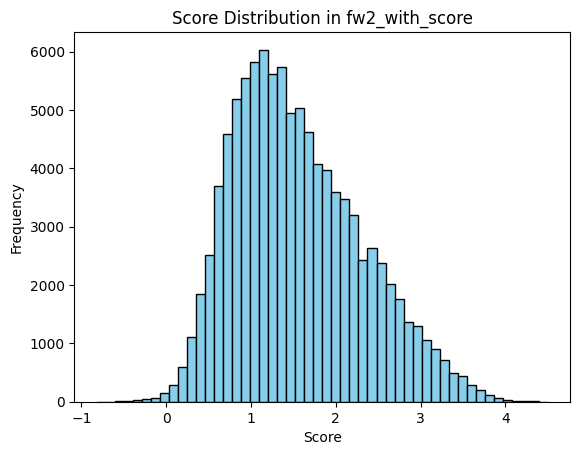

In [6]:
import matplotlib.pyplot as plt

plt.hist(fw2_with_score["score"], bins=50, color='skyblue', edgecolor='black')
plt.title("Score Distribution in fw2_with_score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [7]:
# fw2_with_score.push_to_hub("minpeter/fineweb-2-edu-korean-scored")
fw2_with_score.save_to_disk("artifacts/dataset/fineweb-2-edu-korean-scored")


Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]


Saving the dataset (0/1 shards):  31%|▎| 31000/100000 [00:00<00:00, 291483.32 exam


Saving the dataset (0/1 shards):  62%|▌| 62000/100000 [00:00<00:00, 299977.16 exam


Saving the dataset (0/1 shards):  94%|▉| 94000/100000 [00:00<00:00, 303454.41 exam


Saving the dataset (1/1 shards): 100%|█| 100000/100000 [00:00<00:00, 303454.41 exa


Saving the dataset (1/1 shards): 100%|█| 100000/100000 [00:00<00:00, 300991.03 exa